   Unnamed: 0       Id_recorrido duracion_recorrido fecha_origen_recorrido  \
0           1  17910696BAEcobici              1,848    2023-04-24 10:30:10   
1           2  17600256BAEcobici                288    2023-03-22 17:40:55   
2           3  17255670BAEcobici              1,103    2023-02-15 23:12:22   
3           4  17996972BAEcobici              1,165    2023-05-03 11:00:20   
4           5  17148836BAEcobici                378    2023-02-06 06:50:58   

  id_estacion_origen        nombre_estacion_origen  \
0       358BAEcobici                  249 - Balbín   
1       444BAEcobici  061 - Ministerio de Economia   
2       280BAEcobici           222 - SIMON BOLIVAR   
3       273BAEcobici                  223 - GAINZA   
4        65BAEcobici          065 - Julián Álvarez   

           direccion_estacion_origen  long_estacion_origen  \
0                        2519 Conesa            -58.465586   
1  Balcarce e Yrigoyen, Hipolito Av.            -58.370716   
2   1701 Fernandez M

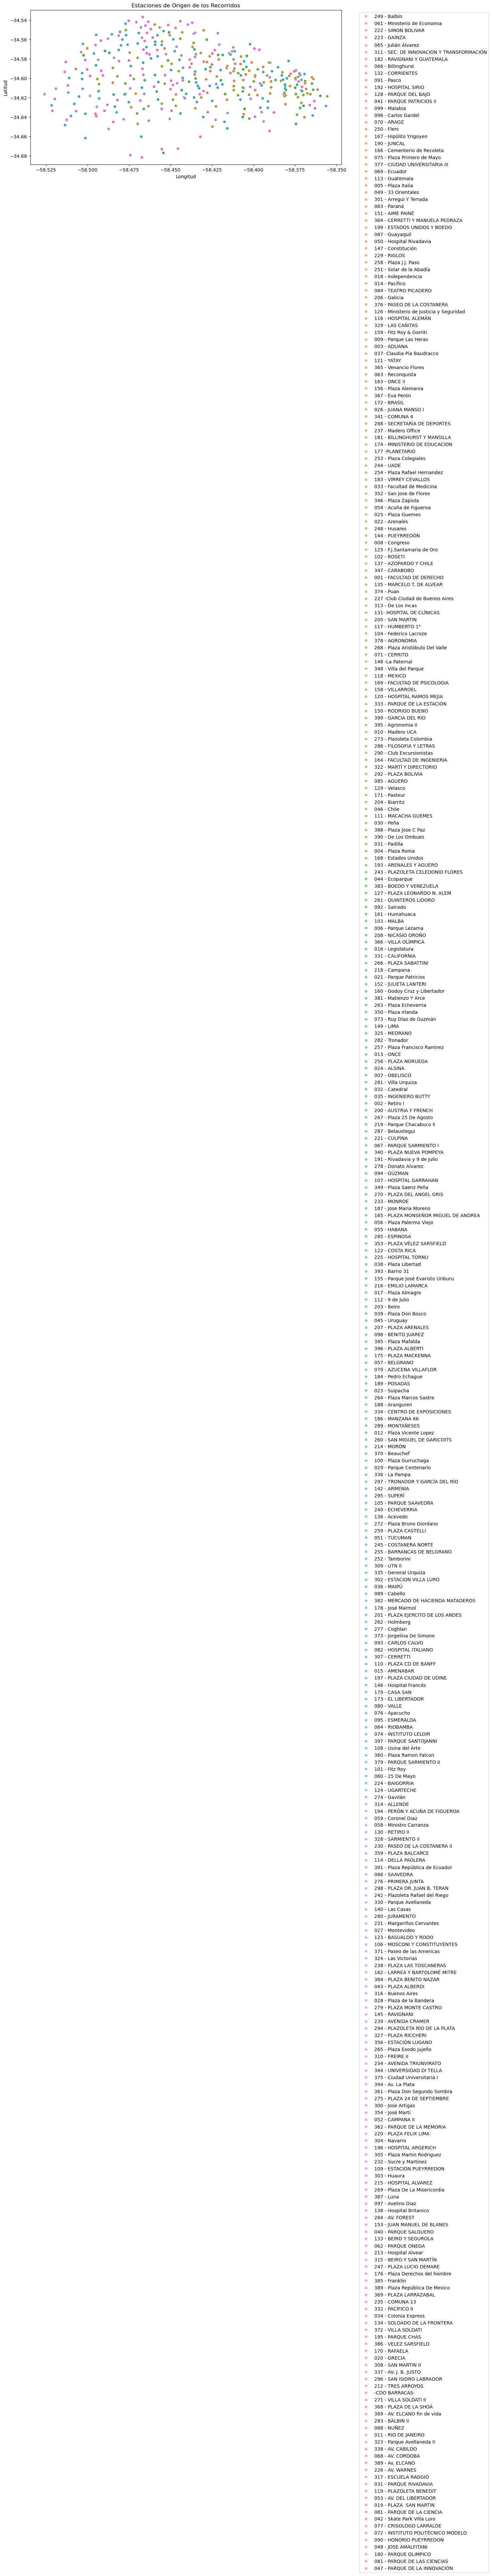

In [4]:
# id_recorrido,duracion_recorrido,fecha_origen_recorrido,id_estacion_origen,nombre_estacion_origen,direccion_estacion_origen,long_estacion_origen,lat_estacion_origen,fecha_destino_recorrido,id_estacion_destino,nombre_estacion_destino,direccion_estacion_destino,long_estacion_destino,lat_estacion_destino,id_usuario,modelo_bicicleta,genero
# estas son las columnas del dataset que tenemos con los recorridos de bicicletas por la ciudad de Buenos Aires.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
# Cargar el dataset
df = pd.read_csv('data/raw/trips_2023.csv')
# Mostrar las primeras filas del dataset
print(df.head())
# Verificar si hay valores nulos
print(df.isnull().sum())
# Eliminar filas con valores nulos
df = df.dropna()
# Convertir la columna de fecha a tipo datetime
df['fecha_origen_recorrido'] = pd.to_datetime(df['fecha_origen_recorrido'])
df['fecha_destino_recorrido'] = pd.to_datetime(df['fecha_destino_recorrido'])
# Calcular la duración del recorrido en minutos
df['duracion_recorrido'] = (df['fecha_destino_recorrido'] - df['fecha_origen_recorrido']).dt.total_seconds() / 60

# graficar las estaciones de origen y destino
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='long_estacion_origen', y='lat_estacion_origen', hue='nombre_estacion_origen', alpha=0.6)
plt.title('Estaciones de Origen de los Recorridos')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


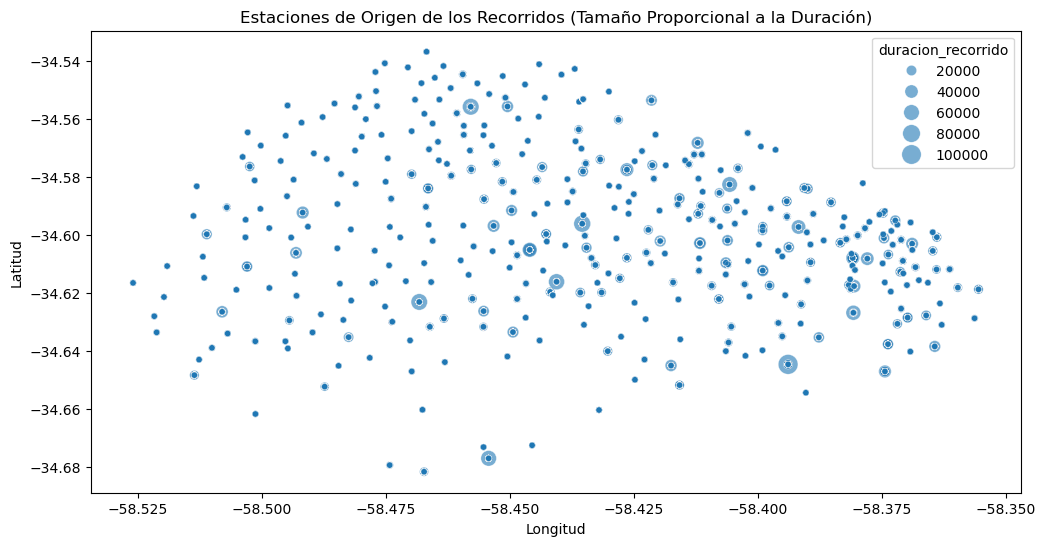

In [5]:
# graficar en el mapa las estaciones, pero que el tamaño de los puntos sea proporcional a la cantidad de recorridos que se inician en cada estación
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='long_estacion_origen', y='lat_estacion_origen', 
                size='duracion_recorrido', sizes=(20, 200), alpha=0.6)
plt.title('Estaciones de Origen de los Recorridos (Tamaño Proporcional a la Duración)')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [6]:
llegadas = df.groupby(['id_estacion_destino', 'nombre_estacion_destino', 'lat_estacion_destino', 'long_estacion_destino']) \
             .size().reset_index(name='cantidad_llegadas')


In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Cargar imagen del mapa
img = mpimg.imread('A0_transporte_0-1.png')

# Crear el gráfico
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(img, extent=[-58.52114, -58.3348, -34.6877, -34.53640])  # ajustar según coordenadas de CABA

# Graficar las estaciones
ax.scatter(
    llegadas['long_estacion_destino'],
    llegadas['lat_estacion_destino'],
    s=llegadas['cantidad_llegadas']/ 100,  # ajustar el tamaño de los puntos
    alpha=0.6,
    c='red',
    edgecolor='black'
)

ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")
ax.set_title("Cantidad de llegadas por estación")
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'A0_transporte_0-1.png'

In [8]:
import folium

# Centro aproximado de CABA
m = folium.Map(location=[-34.61, -58.42], zoom_start=12)

# Agregar estaciones con circulos más pequeños
for _, row in llegadas.iterrows():
    folium.CircleMarker(
        location=[row['lat_estacion_destino'], row['long_estacion_destino']],
        radius=row['cantidad_llegadas'] / 1500,  # reduciendo el tamaño de los puntos
        popup=row['nombre_estacion_destino'],
        color='crimson',
        fill=True,
        fill_opacity=0.6
    ).add_to(m)

# Guardar o mostrar
m.save("mapa_llegadas.html")


In [9]:
salidas = df.groupby(
    ['id_estacion_origen', 'nombre_estacion_origen', 'lat_estacion_origen', 'long_estacion_origen']
).size().reset_index(name='cantidad_salidas')


In [10]:
# Mapa centrado en CABA
m = folium.Map(location=[-34.61, -58.42], zoom_start=12)

# Agregar estaciones con tamaño proporcional a salidas
for _, row in salidas.iterrows():
    folium.CircleMarker(
        location=[row['lat_estacion_origen'], row['long_estacion_origen']],
        radius=row['cantidad_salidas'] / 1500,  # ajustar escala si es necesario
        popup=f"{row['nombre_estacion_origen']}: {row['cantidad_salidas']} salidas",
        color='blue',
        fill=True,
        fill_opacity=0.6
    ).add_to(m)

# Guardar o mostrar
m.save("mapa_salidas.html")


In [ ]:
# Cargar datasets
df_viajes = pd.read_csv("data/raw/trips_2023.csv", parse_dates=["fecha_origen_recorrido", "fecha_destino_recorrido"])
df_usuarios = pd.read_csv("data/raw/usuarios_ecobici_2023.csv", parse_dates=["fecha_alta"])

# Merge viajes con datos de usuario
df = df_viajes.merge(df_usuarios, on="id_usuario", how="left")


FileNotFoundError: [Errno 2] No such file or directory: 'usuarios_ecobici_2023.csv'

In [ ]:
# save df
df.to_csv("data/processed/processed1.csv", index=False)

In [ ]:
import pandas as pd

# Cargar dataset
df = pd.read_csv("data/processed/processed1.csv", parse_dates=["fecha_origen_recorrido", "fecha_destino_recorrido"])

# Parámetro principal
DELTA_MIN = 30  # ΔT = 30 minutos

# Redondeo temporal
df["window_origen"] = df["fecha_origen_recorrido"].dt.floor(f"{DELTA_MIN}min")
df["window_destino"] = df["fecha_destino_recorrido"].dt.floor(f"{DELTA_MIN}min")

# Antigüedad del usuario en días al momento del viaje
df["fecha_alta"] = pd.to_datetime(df["fecha_alta"])
df["antiguedad_dias"] = (df["fecha_origen_recorrido"] - df["fecha_alta"]).dt.total_seconds() / 86400


In [ ]:
# Agrupar por estación y ventana
X = df.groupby(["window_origen", "id_estacion_origen"]).agg(
    cant_partidas=("id_recorrido", "count"),
    edad_promedio=("edad_usuario", "mean"),
    porcentaje_mujeres=("genero_usuario", lambda x: (x == "FEMALE").mean()),
    porcentaje_hombres=("genero_usuario", lambda x: (x == "MALE").mean()),
    antiguedad_promedio=("antiguedad_dias", "mean"),
    lat=("lat_estacion_origen", "first"),
    lon=("long_estacion_origen", "first")
).reset_index()

# Rename por claridad
X = X.rename(columns={"window_origen": "timestamp", "id_estacion_origen": "id_estacion"})


In [ ]:
Y = df.groupby(["window_destino", "id_estacion_destino"]).size().reset_index(name="cant_arribos")
Y = Y.rename(columns={"window_destino": "timestamp", "id_estacion_destino": "id_estacion"})


In [ ]:
# Desplazamos X hacia el futuro
X["target_timestamp"] = X["timestamp"] + pd.Timedelta(minutes=DELTA_MIN)

# Merge con Y
df_final = pd.merge(
    X,
    Y,
    left_on=["target_timestamp", "id_estacion"],
    right_on=["timestamp", "id_estacion"],
    how="inner"
)

# Cleanup final
df_final = df_final.drop(columns=["timestamp_y"])
df_final = df_final.rename(columns={"timestamp_x": "timestamp"})


In [ ]:
df_final["hora"] = df_final["timestamp"].dt.hour
df_final["dia_semana"] = df_final["timestamp"].dt.dayofweek
df_final["mes"] = df_final["timestamp"].dt.month

In [ ]:
# Asegurate que el timestamp esté ordenado
df_final = df_final.sort_values("timestamp")

# Fechas límite para cortes (ajustalas si querés)
fecha_train_val = "2024-07-15"
fecha_val_test = "2024-08-01"

# Split temporal
train = df_final[df_final["timestamp"] < fecha_train_val]
val = df_final[(df_final["timestamp"] >= fecha_train_val) & (df_final["timestamp"] < fecha_val_test)]
test = df_final[df_final["timestamp"] >= fecha_val_test]

print(f"Train: {train.shape}, Val: {val.shape}, Test: {test.shape}")


Train: (174560, 14), Val: (38321, 14), Test: (182608, 14)


In [ ]:
# Elegimos columnas útiles (podés ajustar)
features = [
    "cant_partidas",
    "edad_promedio",
    "porcentaje_mujeres",
    "porcentaje_hombres",
    "antiguedad_promedio",
    "lat", "lon",
    "hora", "dia_semana", "mes"
]

target = "cant_arribos"

# Separar X e Y
X_train, y_train = train[features], train[target]
X_val, y_val = val[features], val[target]
X_test, y_test = test[features], test[target]


In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Modelo
model = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42)
model.fit(X_train, y_train)

# Validación
y_pred_val = model.predict(X_val)

# Evaluación
print("VALIDACIÓN:")
print(f"MAE: {mean_absolute_error(y_val, y_pred_val):.2f}")
print(f"RMSE: {mean_squared_error(y_val, y_pred_val):.2f}")
print(f"R²: {r2_score(y_val, y_pred_val):.2f}")


NameError: name 'X_train' is not defined

In [13]:
# Supongamos que ya tenés estos preprocesados:
# df: el dataset completo con columnas ['window_origen', 'window_destino', 'id_estacion_origen', 'id_estacion_destino', etc.]

ventanas = sorted(df['window_origen'].unique())

def agregar_features_por_estacion(df_input, window_col, estacion_col, prefix):
    df_grouped = df_input.groupby([window_col, estacion_col]).agg(
        cant_partidas=("id_recorrido", "count"),
        edad_promedio=("edad_usuario", "mean"),
        porcentaje_mujeres=("genero_usuario", lambda x: (x == "FEMALE").mean()),
        porcentaje_hombres=("genero_usuario", lambda x: (x == "MALE").mean()),
        antiguedad_promedio=("antiguedad_dias", "mean"),
        lat=("lat_estacion_origen", "first"),
        lon=("long_estacion_origen", "first")
    ).reset_index()

    df_pivot = df_grouped.pivot(index=window_col, columns=estacion_col)
    df_pivot.columns = [f"{prefix}_{e}_{f}" for f, e in df_pivot.columns]
    return df_pivot



KeyError: 'window_origen'

In [ ]:
# X: datos pasados (partidas)
X_full = agregar_features_por_estacion(df, "window_origen", "id_estacion_origen", "X")

# Y: datos futuros (arribos)
Y_grouped = df.groupby(["window_destino", "id_estacion_destino"]).size().unstack().fillna(0)
Y_grouped.columns = [f"Y_{c}" for c in Y_grouped.columns]
Y_grouped.index.name = "window_destino"

# Alinear ventanas
X_full = X_full.sort_index()
Y_grouped = Y_grouped.sort_index()

# Para cada fila en X (ventana T), el Y correspondiente es en T + ΔT
X_full["target_window"] = X_full.index + pd.Timedelta(minutes=DELTA_MIN)

# Merge X con Y
dataset = pd.merge(X_full, Y_grouped, left_on="target_window", right_index=True, how="inner")
dataset = dataset.drop(columns=["target_window"])
